In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [3]:
predictions_dict = {}

In [4]:
config_filename = 'bokaro.yaml'
config = read_config(config_filename)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M0, M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_06112020_tracker.pkl
splitting data ..
TVT:  12 10 0
splitting data ..
TVT:  12 10 0
          date      state district  total  active  recovered  deceased  \
0   2020-04-26  Jharkhand   Bokaro     10       5          4         1   
1   2020-04-27  Jharkhand   Bokaro     10       5          4         1   
2   2020-04-28  Jharkhand   Bokaro     10       5          4         1   
3   2020-04-29  Jharkhand   Bokaro     10       5          4         1   
4   2020-04-30  Jharkhand   Bokaro     10       5          4         1   
..         ...        ...      ...    ...     ...        ...       ...   
189 2020-11-01  Jharkhand   Bokaro   5455     308       5101        46   
190 2020-11-02  Jharkhand   Bokaro   5482     309       5127        46   
191 2020-11-03  Jharkhand   Bokaro   5509     261       5202        46   
192 2020-11-04  Jharkhand   Bokaro   5518     235       5237        46   
193 2020-11-05  Jharkhand   Bokaro  

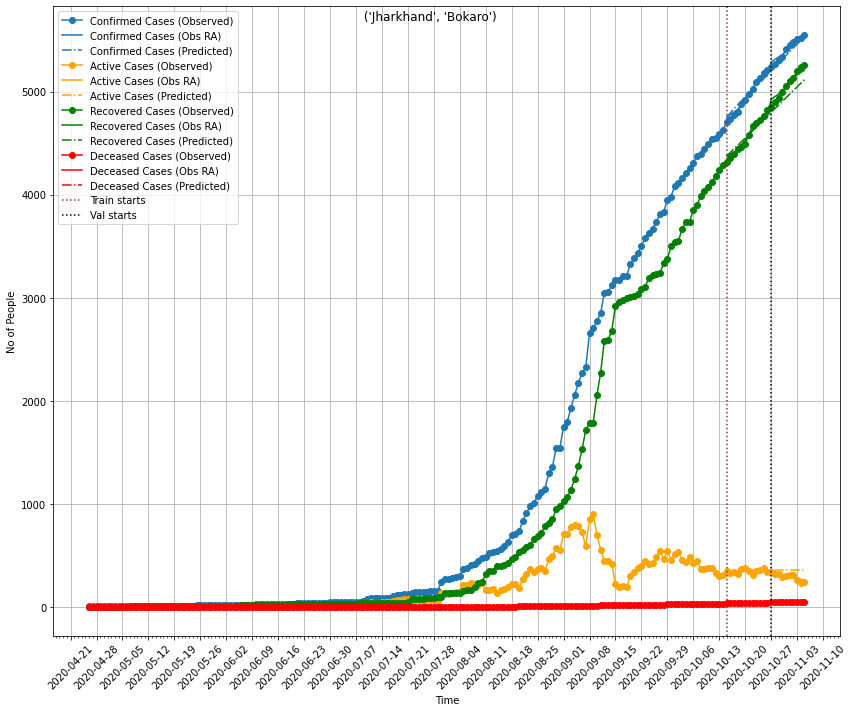

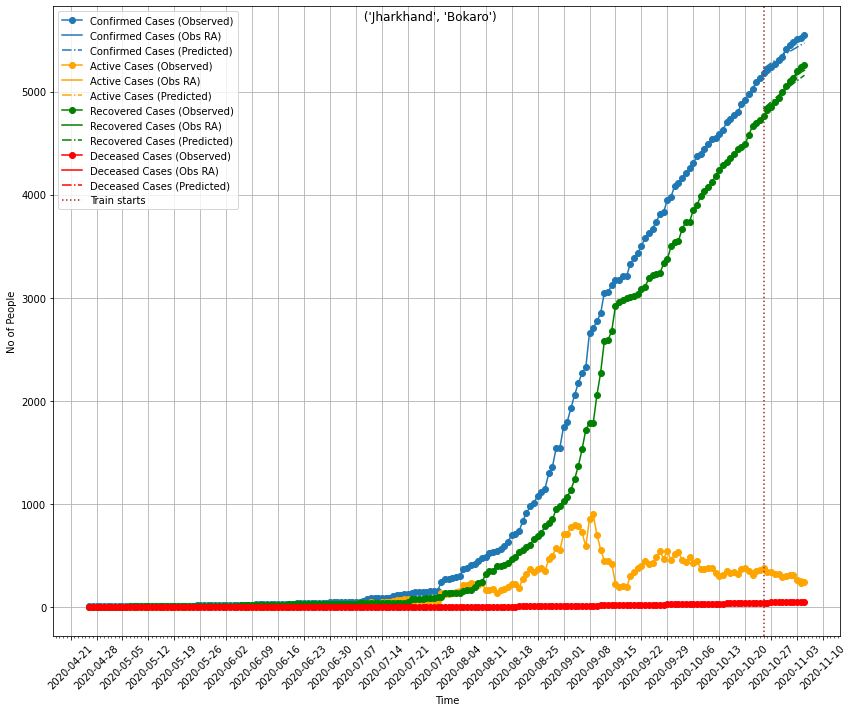

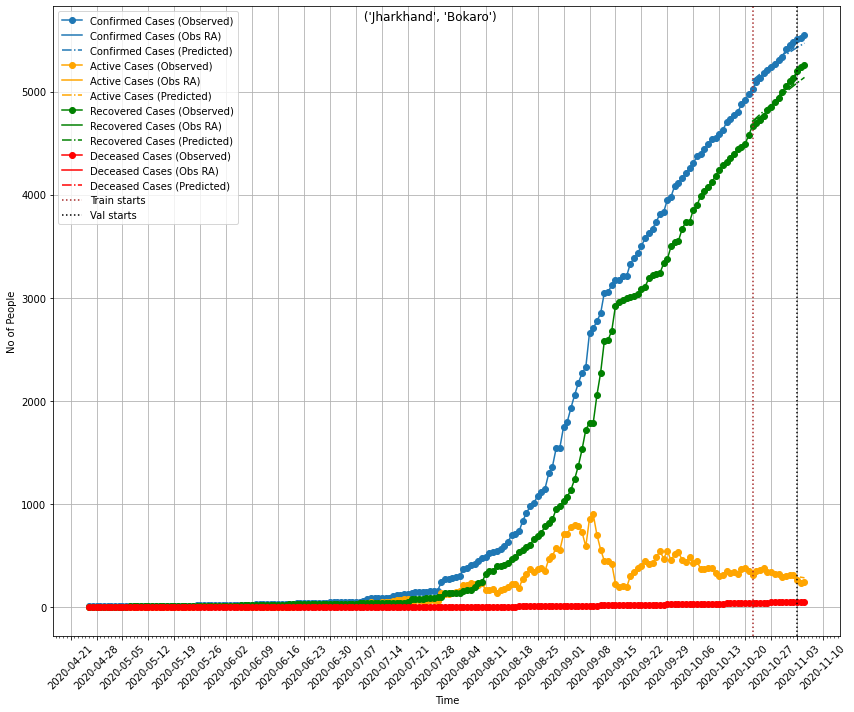

In [6]:
train_period, val_period, test_period = config['fitting']['split']['train_period'], config['fitting']['split']['val_period'], config['fitting']['split']['test_period']

m0_params = copy.deepcopy(config['fitting'])
m1_params = copy.deepcopy(config['fitting'])
m2_params = copy.deepcopy(config['fitting'])

m0_params['split']['val_period'] = test_period
m0_params['split']['test_period'] = 0

m1_params['split']['val_period'] = 0
m1_params['split']['test_period'] = 0

m2_params['split']['test_period'] = 0

# print(m2_params['split'])
predictions_dict['m0'] = single_fitting_cycle(**m0_params)
predictions_dict['m1'] = single_fitting_cycle(**m1_params) 
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
predictions_dict['m0']['best_params']

{'E_hosp_ratio': 0.42156093749845436,
 'I_hosp_ratio': 0.49756828759568905,
 'P_fatal': 0.03429641781371205,
 'T_inc': 4.541951962871457,
 'T_inf': 3.8627770860637716,
 'T_recov': 9.64853821575528,
 'T_recov_fatal': 24.625968221393382,
 'lockdown_R0': 0.9916933509222602}

In [8]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.19952554314225063,
 'I_hosp_ratio': 0.28062398479179895,
 'P_fatal': 0.012105103947953354,
 'T_inc': 4.610030789653439,
 'T_inf': 3.0715604371196013,
 'T_recov': 10.235307498533327,
 'T_recov_fatal': 39.38945857176288,
 'lockdown_R0': 0.9749676160191936}

In [9]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.3453008410044246,
 'I_hosp_ratio': 0.3677477020884201,
 'P_fatal': 0.00993785012280661,
 'T_inc': 4.645431862020921,
 'T_inf': 3.9792922182246206,
 'T_recov': 10.519749576379025,
 'T_recov_fatal': 21.149382287217627,
 'lockdown_R0': 0.7851294703075476}

## Loss Dataframes

## M0 Loss Dataframe

In [10]:
predictions_dict['m0']['df_loss']

train       val
total      0.803993  0.705083
active      4.73951   24.7803
recovered   0.98041   2.17604
deceased   0.954416   11.5217

### M1 Loss DataFrame

In [11]:
predictions_dict['m1']['df_loss']

train
total      0.902532
active       5.5983
recovered   1.07412
deceased   0.543478

### M2 Loss DataFrame

In [12]:
predictions_dict['m2']['df_loss']

train      val
total      0.688052  1.39366
active      3.88895  18.3023
recovered  0.812164  2.34416
deceased   0.362319  2.17391

## Sensitivity Plot

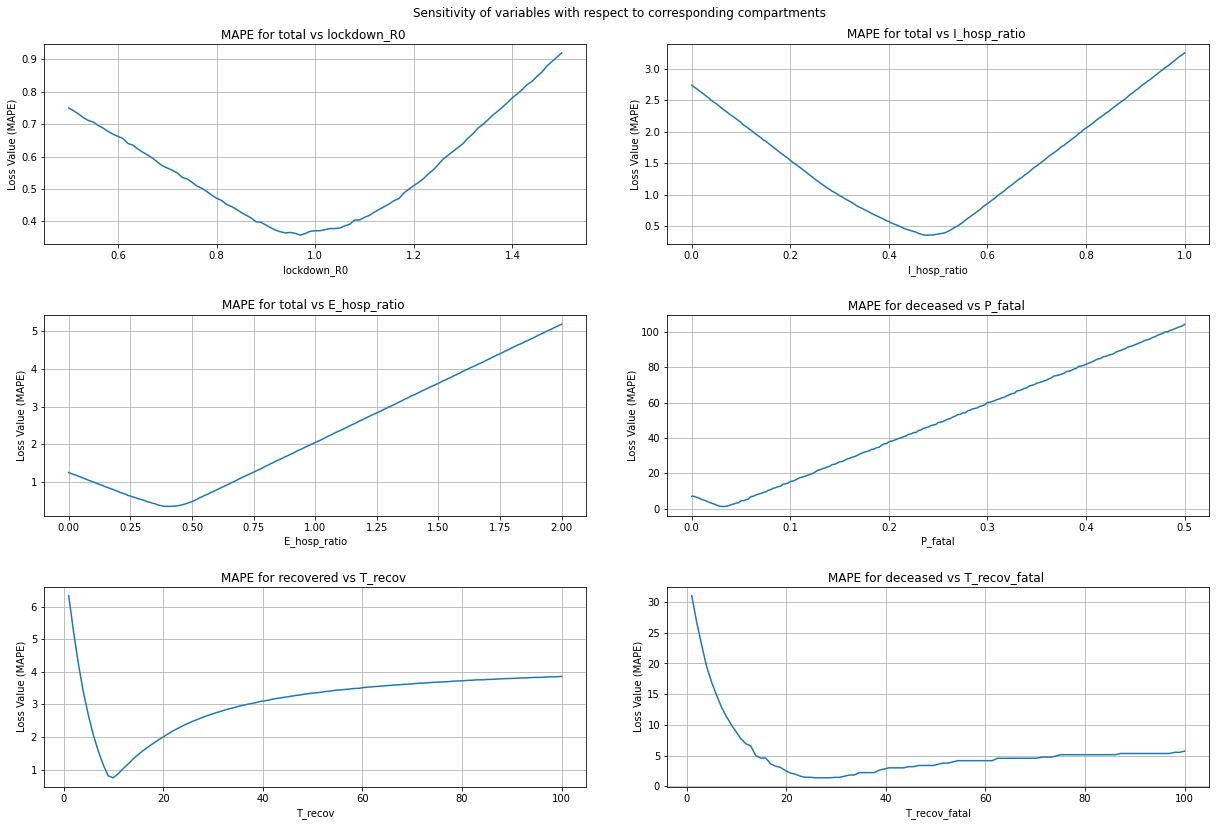

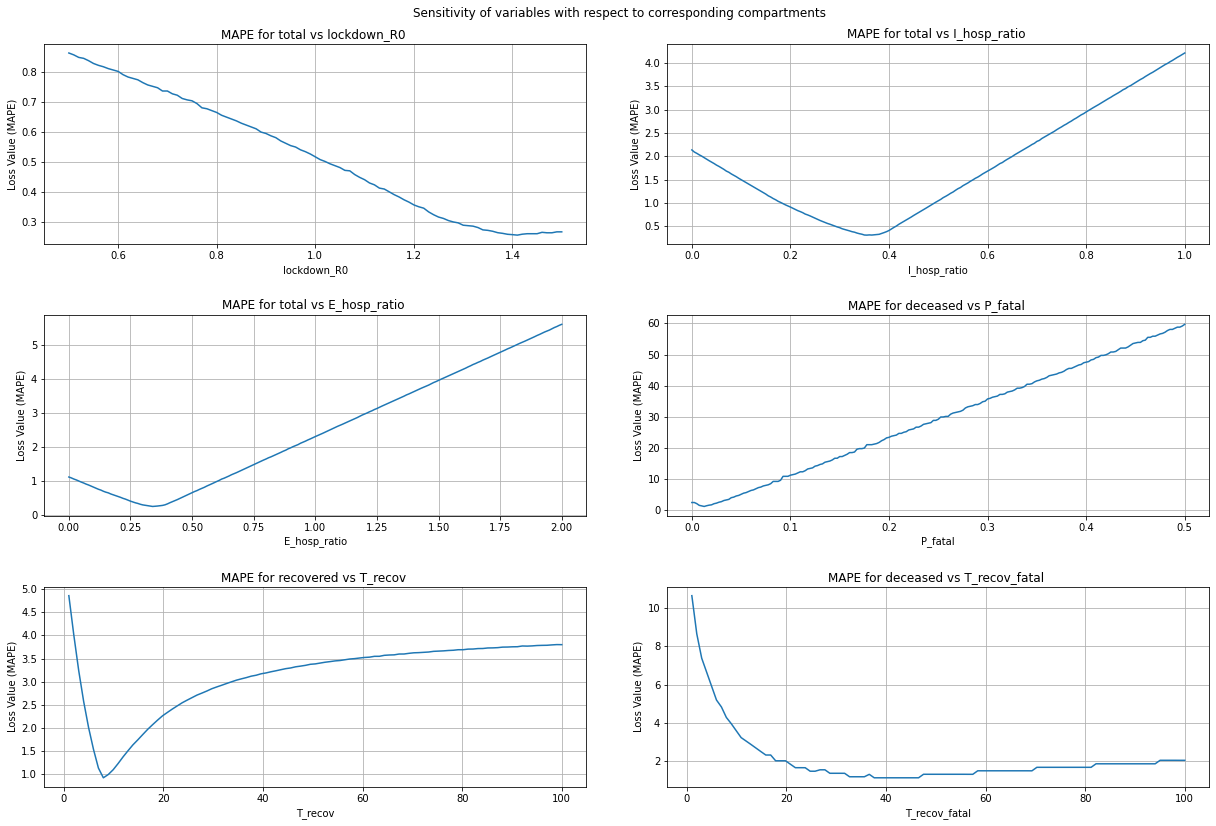

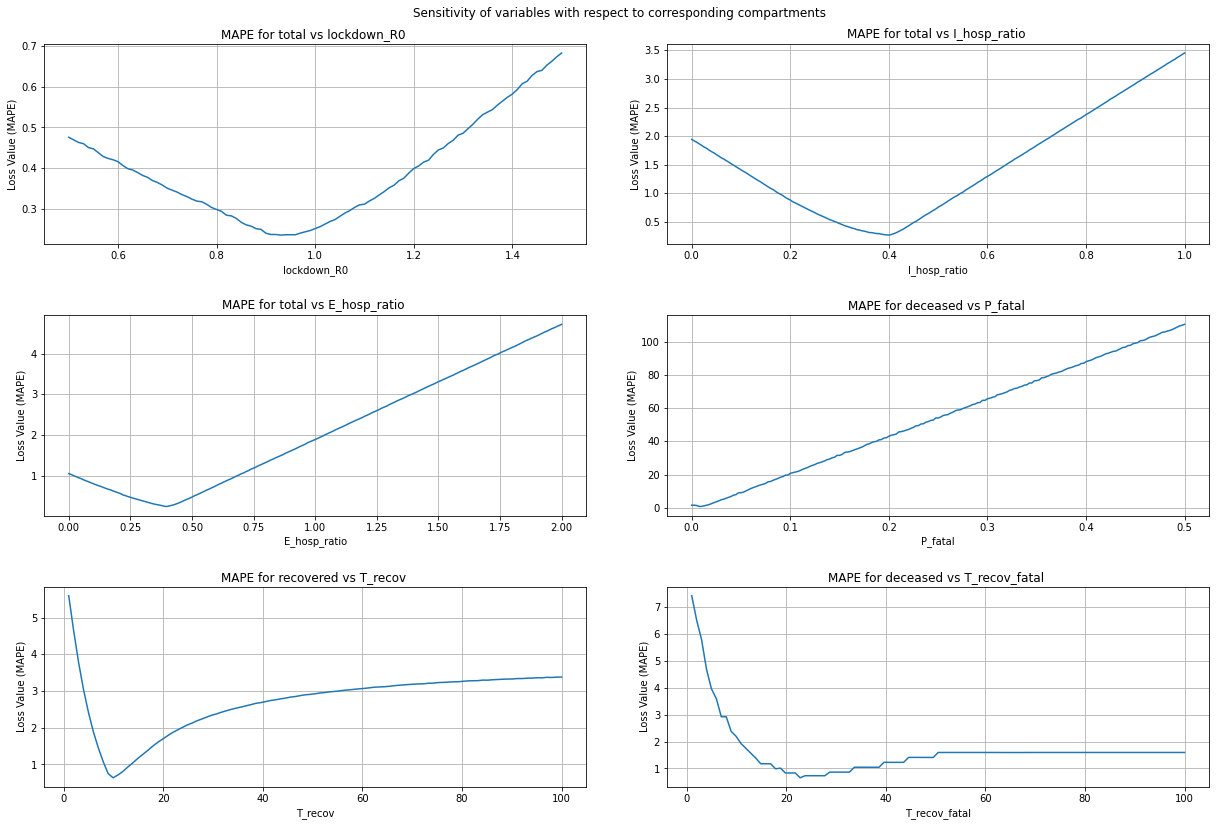

In [13]:
predictions_dict['m0']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m0')
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [14]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m0']['forecasts'] = {}
predictions_dict['m0']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m0', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


In [15]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m1']['forecasts'] = {}
predictions_dict['m1']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m1', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


In [16]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m1', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


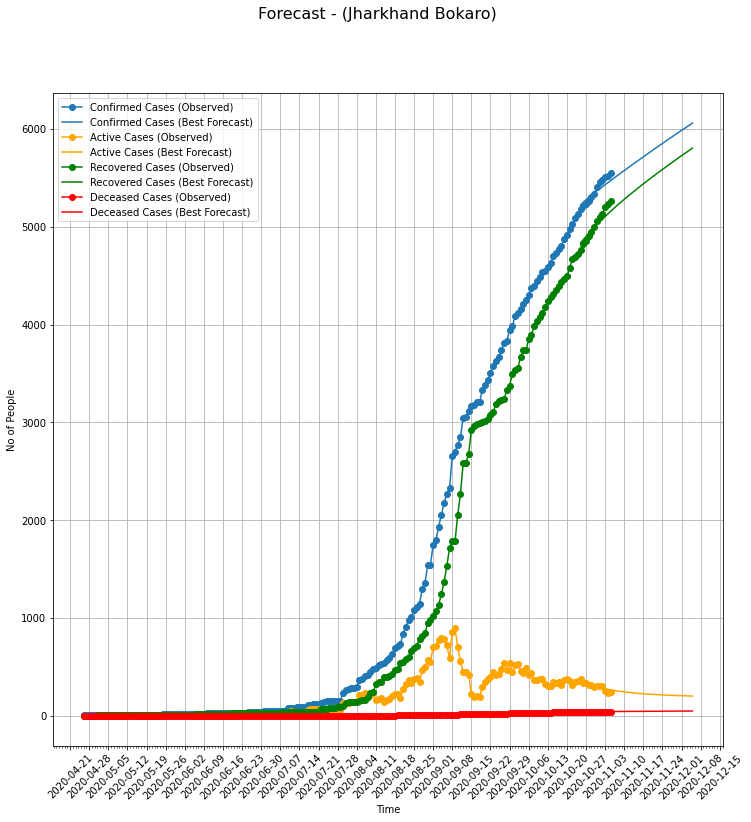

In [17]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m1']['plots']['forecast_best'] = plot_forecast(predictions_dict,
            (config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district']),
            error_bars=True)

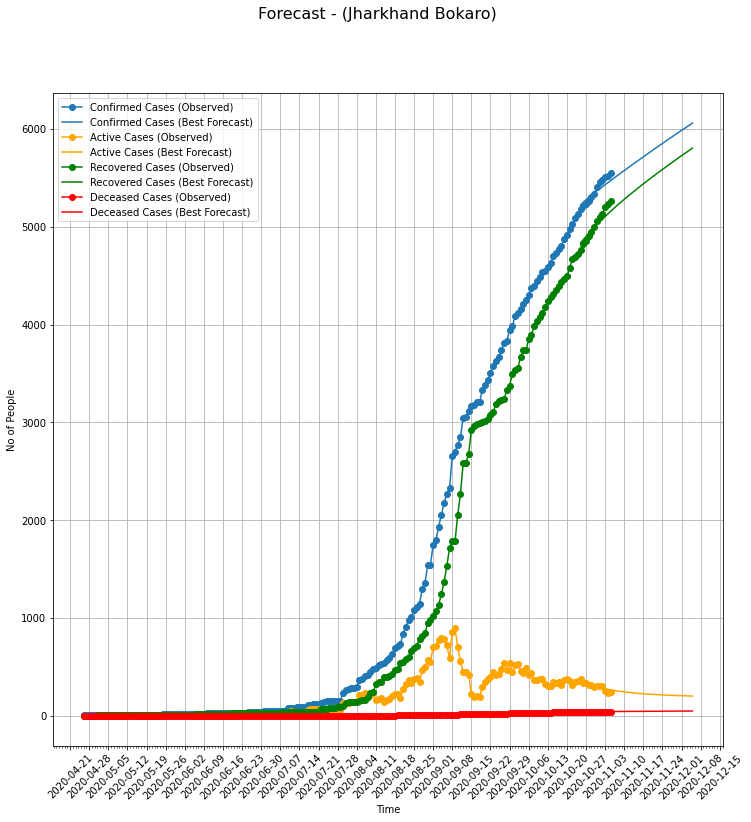

In [18]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict,
            (config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district']), which_fit = 'm2',
            error_bars=True)

In [19]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

10it [00:00, 98.02it/s]getting forecasts ..
1000it [00:10, 98.02it/s]


In [20]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

11it [00:00, 105.15it/s]getting forecasts ..
1000it [00:10, 97.32it/s]


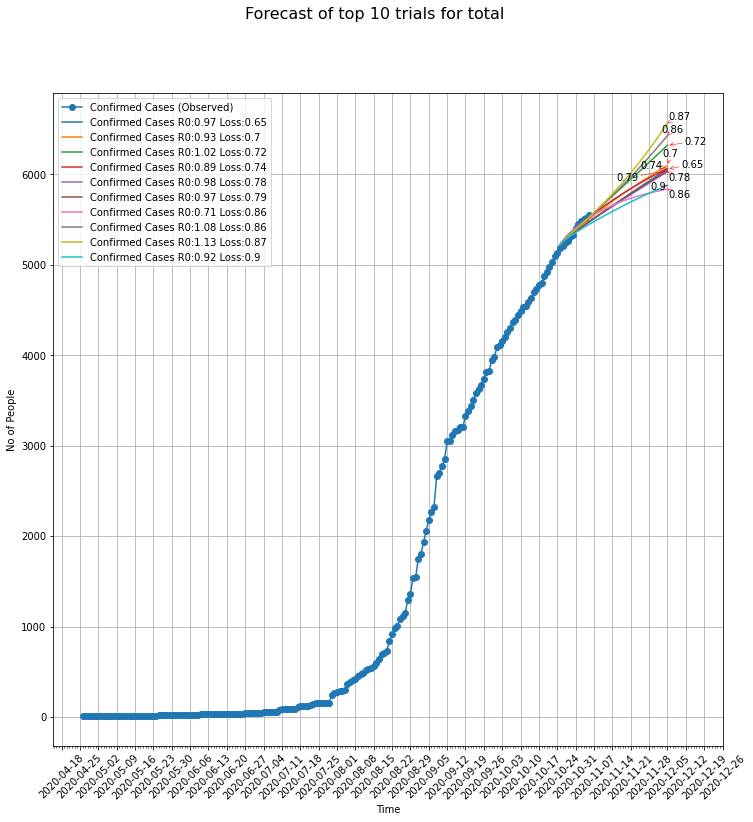

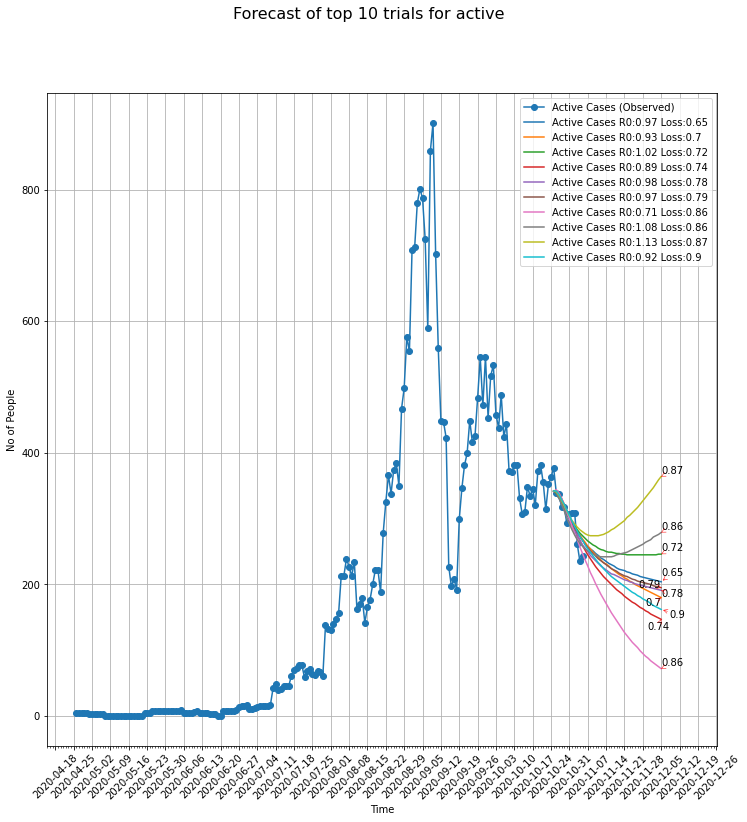

In [21]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m1',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [22]:
predictions_dict['m1']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m1']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [23]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:55<00:00,  1.79trial/s, best loss: 5.6945701699916516]


In [24]:
uncertainty.beta_loss

{'active': 17.653278133516068,
 'recovered': 2.3412596852042373,
 'deceased': 1.3570556466167158,
 'total': 1.4266872146295893}

In [25]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [26]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

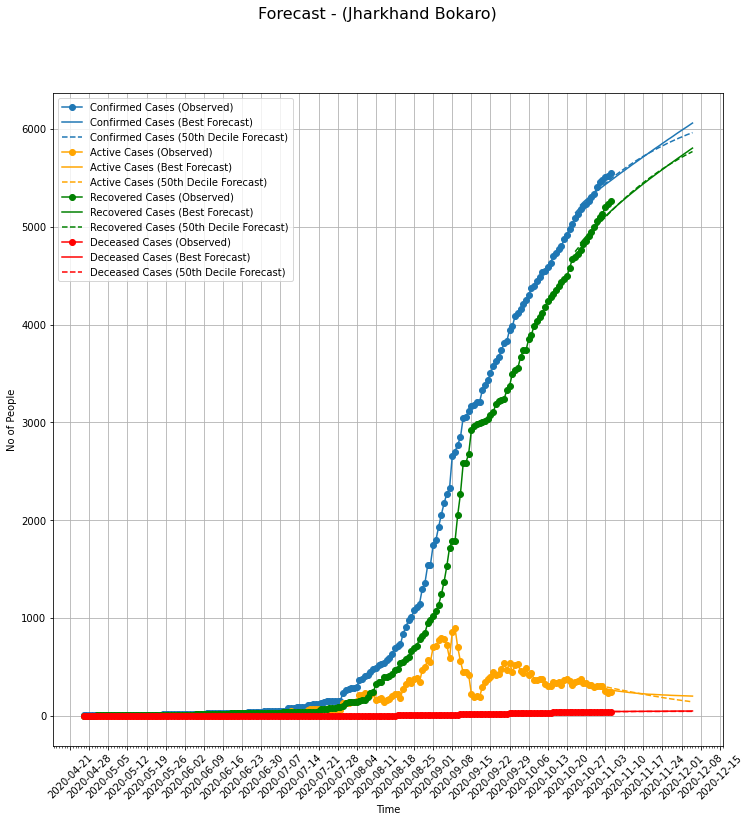

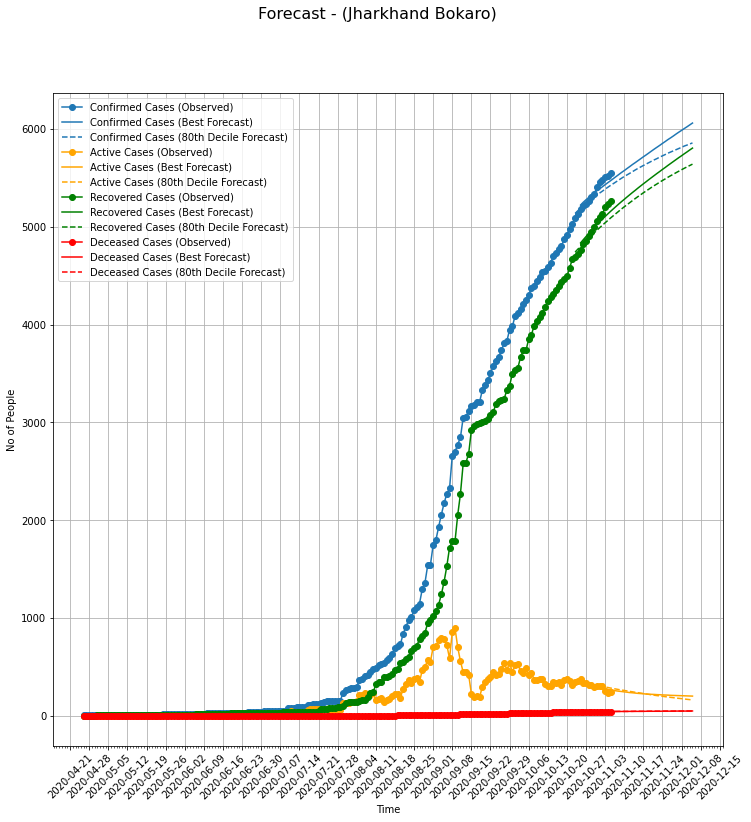

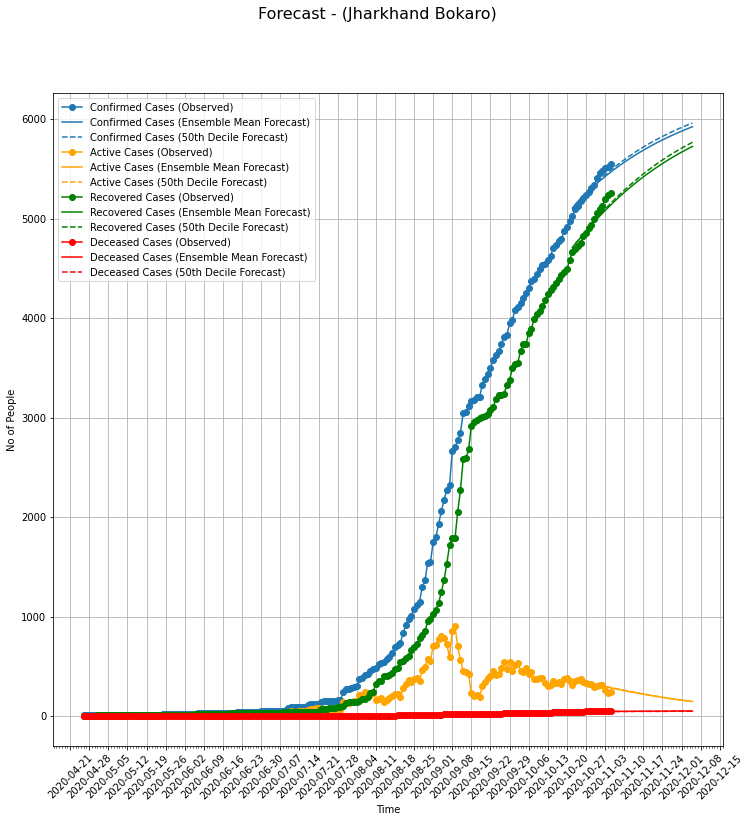

In [27]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

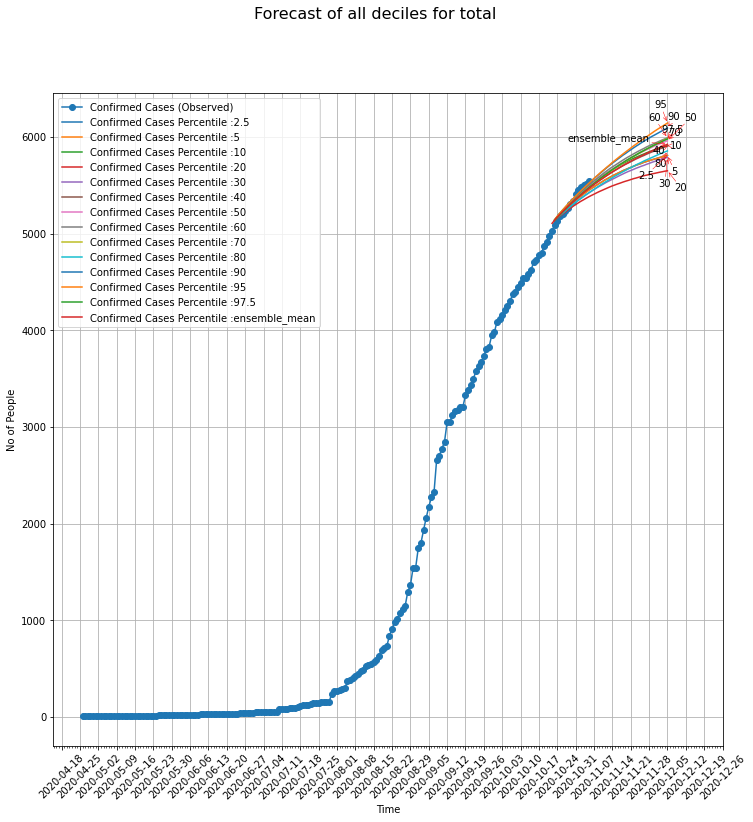

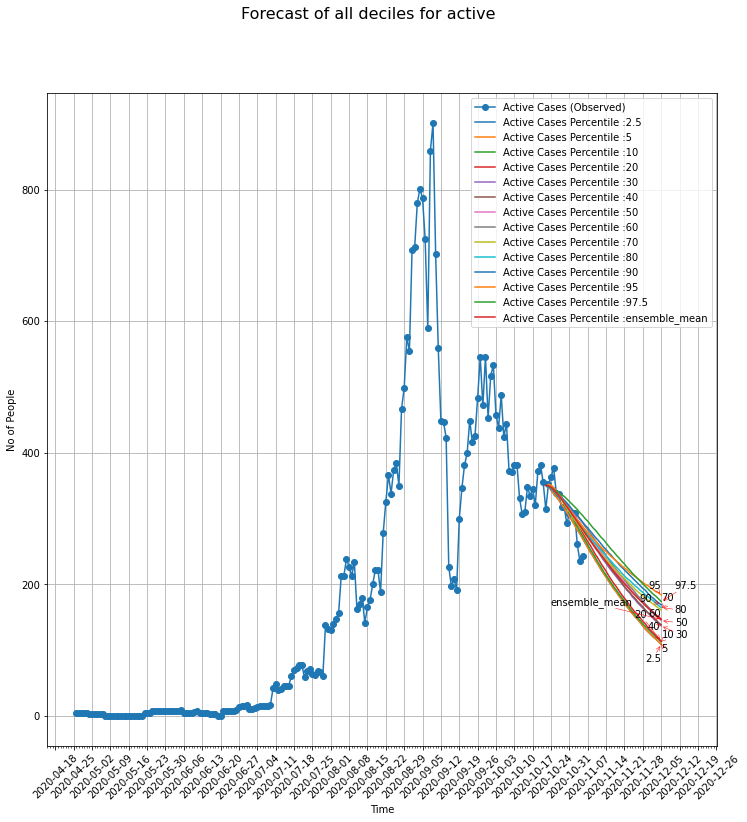

In [28]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


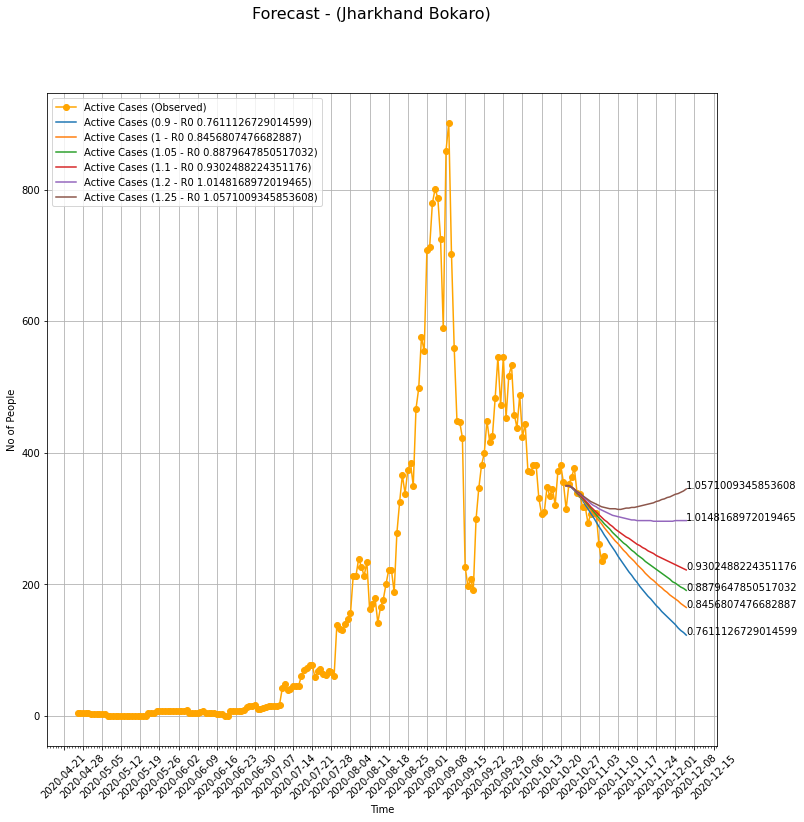

In [29]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_dict['m2']['r0_mul_dict'] = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
predictions_dict['m2']['plots']['r0_mul_dict'] = plot_r0_multipliers(predictions_dict, None, predictions_dict['m2']['r0_mul_dict'], None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [30]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [31]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [32]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [33]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [34]:
save_r0_mul(predictions_dict['m2']['r0_mul_dict'], output_folder)

## Create df_district Output

In [35]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')